#### Panel Data

A panel is when you have multiple units $i$ over multiple periods of time $t$. The fact that you observe the same unit in multiple time periods allows you to see, for the same unit, what happens before and after treatment. This makes panel data a promising alternative to identifying causal effects when randomization is not possible. When you have observational (nonrandomized) data and the likely presence of unobserved confounders, panel data methods are as good as it gets in terms of properly identifying the treatment effect.

Panel data is also known as longitudinal data. Another type of data is cross-sectional data which is characterized by each unit appearing only once. A third category, repeated cross-sectional data, involves multiple time entries, but the units in each time entry are not necessarily the same. Pooled cross-section is data that includes repeated observations of the same unit over time but that is treated as cross-sectional.

In [1]:
from toolz import *

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

In [2]:
mkt_data = (pd.read_csv('data/short_offline_mkt_south.csv').astype({"date": "datetime64[ns]"}))
mkt_data.head()

,date,city,region,treated,tau,downloads,post
0,2021-05-01,5,S,0,0.0,51.0,0
1,2021-05-02,5,S,0,0.0,51.0,0
2,2021-05-03,5,S,0,0.0,51.0,0
3,2021-05-04,5,S,0,0.0,50.0,0
4,2021-05-05,5,S,0,0.0,49.0,0


In [6]:
mkt_data.city.nunique()       # 51 cities

51

In [4]:
mkt_data.shape

(1632, 7)

In [5]:
mkt_data.query("city==5").shape  # 32 time periods for each city

(32, 7)

In [7]:
32*51       # 32 observations each across 51 city ids

1632

The data for this section is marketing data in a panel format. Each line is a day-city combination. The data frame is sorted by date and city. The outcome variable is number of downloads. $D$ is used to denote treatment here, which is often referred to as an intervention in panel data literature. The cities that received an offline campaign are identified with $D_i=1$, and those that did not are identified with $D=0$. For the time dimension, $T$ will be the number of periods, with $T_{pre}$ being the periods before the intervention, ie $t=${$1,2,...,T_{pre},T_{pre}+1, ..., T$}. Periods after intervention, $T_{pre}, .... , T$ are called post intervention. To identify the post-intervention time periods, a Post dummy is used, which is 1 when $t>T_{pre}$ and 0 otherwise. The intervention only happens to treated units, $D=1$, at the post-intervention period, $t>T_{pre}$. The combination of treatment and post intervention will be denoted as $W=D*$𝟙$(t>T_{pre})$ or $W=D*Post$. Note that all time perids that are post-intervention are marked by Post dummy equal to 1, even if that record belongs to a control unit (city). 

Imagine you are tracking sales and the intervention happens starting Christmas day, it is reasonable that there might be an uptick in sales even in control cities after post-intervention date even with no intervention there.
Now in this dataset, we want to understand the effect of offline marketing campaign on cities that got treated, after the treatment takes place:

$ATT = E[Y_{it}(1) - Y_{it}(0)|D=1, t>T_{pre}]$

The value we are seeking is the $ATT$ because we are only focusing on understanding the impact the campaign had on cities with $D=1$, after the campaign was launched $t>T_{pre}$. Since $Y_{it}(1)$ is observable, we can achieve this goal by imputing the missing potential outcome $E[Y(0)|D=1, Post=1]$. $Y(1)$ is only observable for treated units during the post-treatment period, while for all other cells, you can observe $Y(0)$, at all periods ie $E[Y(0)|D=0, t<T_{pre}]$ and $E[Y(0)|D=0, t>T_{pre}]$ . These other cells are still useful for estimating the missing potential outcome $E[Y(0)|D=1, t>T_{pre}]$. Specifically you leverage the correlation between units by using the outcome of control units in the post-intervention period $E[Y(0)|D=0, t>T_{pre}]$ and you leverage the correlation across time by using the treated units' outcome in the pre-treatment period, $E[Y(0)|D=0, t<T_{pre}]$. 

In applications with panel data, we focus on $ATT$ because it is much easier to impute $Y(0)$ for treated units. If instead you wanted the $ATC$ (average effect on the control), you would have to impute $Y(1)$ and that potential outcome is only observable you in the post-intervention period of treated units.

In [8]:
(mkt_data
 .assign(w=lambda d: d["treated"]*d["post"])  # add a column combining treatment and post-intervention period
 .groupby(["w"])    # group by treatment-intervention values to identify pre/post-intervention 
 .agg({"date": [min, max]}) # get start and end of pre/post intervention
)

date           
         min        max
w                      
0 2021-05-01 2021-06-01
1 2021-05-15 2021-06-01

In [9]:
mkt_data.date.max()

Timestamp('2021-06-01 00:00:00')

In [12]:
mkt_data.query("(treated==1)&(post==0)").city.unique()  # cities that were actually treated

array([ 30,  71, 100, 107, 127, 137, 146, 189, 197])

In [13]:
mkt_data.query("treated==1").city.unique()  # cities that are in the treated group

array([ 30,  71, 100, 107, 127, 137, 146, 189, 197])

#### Canonical Difference-in-Differences

The idea behind difference-in-differences is, impute the missing potential outcome $E[Y(0)|D=1,Post=1]$ using baseline from treated units, but applying evolution of outcome (growth) from control units:

$E[Y(0)|D=1, Post=1]= E[Y|D=1,Post=0] + (E[Y|D=0, Post=1]-E[Y|D=0, Post=0])$

The potential outcome estimation, $E[Y(0)|D=1, Post=1]$, is done by replacing the righthand side expectations with sample averages. The reason this is called difference-in-differences (DID) estimator is because, if you substitute the preceding equation for $E[Y(0)|D=1, Post=1]$ in the $ATT$, you literally get the difference in differences.

$ATT=(E[Y|D=1, Post=1]-E[Y|D=1, Post=0])\\ \;\; - (E[Y|D=0, Post=1] - E[Y|D=0, Post=0])$

To get the difference-in-differences (DID) estimate, first divide the time periods into pre- and post-intervention. Then divide the units into treated and control group. Then compute the averages of all four cells: pre-treatment and control, pre-treatment and treated, post-treatment and control, post-treatment and treated.

In [14]:
did_data = (mkt_data
            .groupby(["treated", "post"])                  # assigning treated first makes access easier below
            .agg({"downloads": "mean", "date": "min"})
            )
did_data

downloads       date
treated post                      
0       0     50.335034 2021-05-01
        1     50.556878 2021-05-15
1       0     50.944444 2021-05-01
        1     51.858025 2021-05-15

In [19]:
# DID estimate of ATT
y0_est =(did_data.loc[1].loc[0,"downloads"]                 # treated baseline
         # control evolution
         + did_data.loc[0].diff().loc[1, "downloads"])      # pd.Series.diff() difference with previous row  

att = did_data.loc[1].loc[1, "downloads"] - y0_est
att

0.6917359536407233

In [20]:
# comparing DID estimate with true ATT of simulated data
mkt_data.query("post==1").query("treated==1")["tau"].mean()

0.7660316402518457

#### Diff-in-Diff with Outcome Growth

DID is differentiating the data in the time dimension. The difference in outcome across time for unit $i$ is

$\Delta y_i = E[y_i|t>T_{pre}]-E[y_i|t\leq T_{pre}]$

After differentiating out the time dimension, we can use potential outcome notation to define the ATT in terms of $\Delta y$ between the treated $D=1$ and control group $D=0$, which DID tries to identify by replacing $\Delta y_0$ with the average of the control units:

$ATT=E[\Delta y_1 - \Delta y_0]$ 


$ATT=E[\Delta y | D=1] - E[\Delta y | D=0]$



In [27]:
# mean download before pre-intervention by city (even control city cos pre-intervention is only about the dates)
pre = mkt_data.query("post==0").groupby("city")["downloads"].mean()     # pre-intervention city average
post = mkt_data.query("post==1").groupby("city")["downloads"].mean()    # post-intervention city average

In [33]:
delta_y = ((post - pre)  # for each city, difference between the average post and pre intervention outcomes
           .rename("delta_y")
           .to_frame()              # convert Series to DataFrame
           # add the treatment dummy
           .join(mkt_data.groupby("city")["treated"].max()) # index is city after group. join merges on index
           )
delta_y.tail()

,delta_y,treated
city,,
192,0.555556,0
193,0.166667,0
195,0.420635,0
196,0.119048,0
197,1.595238,1


In [34]:
(delta_y.query("treated==1")["delta_y"].mean()      # average (expected) delta y for treated cities
 - delta_y.query("treated==0")["delta_y"].mean())   # average (expected) delta y for control cities

0.6917359536407155

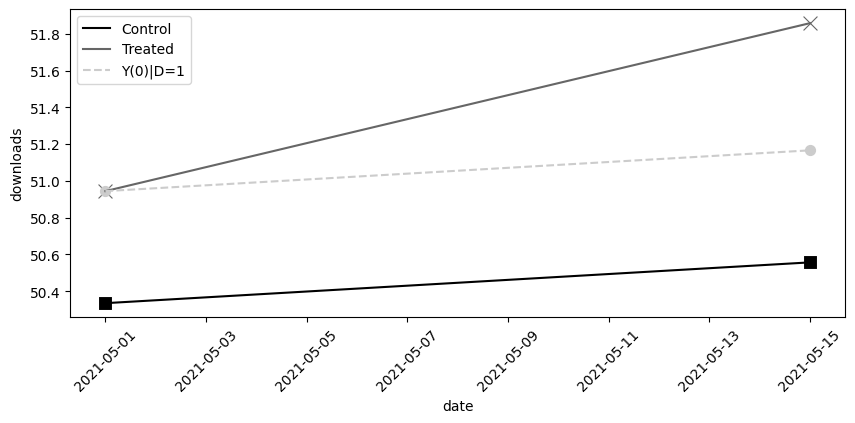

In [38]:
did_plt = did_data.reset_index()  # dataframe of treated, post status, average outcome and min date columns

plt.figure(figsize=(10,4))

# Growth of E[Y|D=0] from Post=0 to Post=1
sns.scatterplot(data=did_plt.query("treated==0"), x="date", y="downloads", s=100, color="C0", marker="s")
sns.lineplot(data=did_plt.query("treated==0"), x="date", y="downloads", label="Control", color="C0")

# Growth of E[Y|D=1] from Post=0 to Post=1
sns.scatterplot(data=did_plt.query("treated==1"), x="date", y="downloads", s=100, color="C1", marker="x")
sns.lineplot(data=did_plt.query("treated==1"), x="date", y="downloads", label="Treated", color="C1")

# Growth of E[Y(0)|D=1] from Post=0 to Post=1
plt.plot(did_data.loc[1,"date"], [did_data.loc[1, "downloads"][0], y0_est], 
         color="C2", linestyle="dashed", label="Y(0)|D=1") 
plt.scatter(did_data.loc[1,"date"], [did_data.loc[1, "downloads"][0], y0_est], color="C2", s=50)

plt.xticks(rotation=45)
plt.legend()

#### Diff-in-Diff with OLS

Even though you can implement DID by computing averages or taking deltas, you can estimate it using a saturated regression. For the example data, first group daily data by unit (treated and control cities) and time (post- and pre-treatment period) . Then for each city and period combination, get the average number of daily downloads (also we get start date for each period and treatment status for each city for good understanding of when and where treatment takes place). With this city by period dataset, you can estimate the following linear model:

$Y_{it} = \beta_0 + \beta_1D_i + \beta_2Post_t + \beta_3D_iPost_t + e_{it}$

and parameter estimate $\hat \beta_3$ will be the DID estimate. $\beta _0$ is the baseline of the control (everything turned off). In this case, $\beta _0$ is the level of downloads in control cities, prior to 2021-05-15 ie $D_i=0$ and $Post_i = 0$. If you turn on the treated city dummy ie $D_i=1$, you get $\beta_0 + \beta_1$. So $\beta_0 + \beta_1$ is the baseline of treated cities, also before intervention. $\beta_1$ is simply the difference in baseline between treated and control cities. If you turn the treatment dummy off and turn the post-treatment dummy on, you get $\beta_0+\beta_2$, which is the level of the control cities after the intervention. $\beta_2$ is then the trend of the control. Its how much the control grows from the pre- to the post-intervention period. Again,
$\beta_1$ is the increment you get going from control to treated, $\beta_2$ is the increment you get by going from pre- to post-treatment period. If you turn both treated and post dummies on, you get $\beta_0+\beta_1+\beta_2+\beta_3$. This is the level of the treated cities after the intervention, which means that $\beta_3$ is the increment in the outcome you get by going from control to treated cities and from pre- to post-intervention period. In ohterwords, $\beta_3$ is the differences-in-differences estimator.

In [42]:
did_data = (mkt_data 
            .groupby(["city", "post"])              # for each city, pre-/post-intervention dates pair
            .agg({"downloads": "mean",              # average outcome
                  "date": "min",                    # earliest date in each pre-/post-intervention date
                  "treated": "max"})                # city a treated / control unit
            .reset_index())                         # make city, post groupings into columns
did_data.head()

,city,post,downloads,date,treated
0,5,0,50.642857,2021-05-01,0
1,5,1,50.166667,2021-05-15,0
2,15,0,49.142857,2021-05-01,0
3,15,1,49.166667,2021-05-15,0
4,20,0,48.785714,2021-05-01,0


In [43]:
import statsmodels.formula.api as smf

smf.ols(
    "downloads ~ treated*post", data=did_data   # * for interaction and individual terms
).fit().params["treated:post"]                  # read the coefficient for the interaction term 

0.6917359536407034

#### Diff-in-Diff with Fixed Effects

Another way to understand DID is with time- and unit-fixed effect model (two-way fixed effects or TWFE). In this model, you have treatment effect $\tau$, unit- and time-fixed effects, $\alpha_i$ and $\gamma_t$, respectively.

$Y_{it}=\tau W_{it} + \alpha_i + \gamma_t + e_{it}$

where $W_{it}=D_i Post_i$ and $_{it}$ refers to unit $i$ and treatment $t$ (since treatment is a function of the unit and time; only some units are treated and that only after a certain time). If you estimate this model, the parameter estimate associated with $W$ will match the DID estimate and recover the ATT. You can estimate fixed effects by using dummies or de-meaning the data. To use the dummies approach here, we include the city and period dummies with $C(city)$ and $C(post)$. Also, you need to create $W$ by multiplying the treated and the post dummies. The * operator creates the interaction between two terms and includes the terms themselves. Since we only want the interaction, we need the : operator.

In [44]:
# treatment effect + unit effect + period effect
m = smf.ols('downloads ~ treated:post + C(city) + C(post)', data=did_data).fit() # : for interaction term only
m.params["treated:post"]  # read the parameter associated with interaction term only

0.6917359536407011

#### Multiple Time Periods

Canonical DID requires only four data cells: pre- and post- intervention, treated and control groups. It doesnt require that the pre and post time be aggregated into a single block. Canonical DID only requires that you have a block design: a group of units that are never treated and a group of units that are eventually treated at the same time period. That is, you can't have the treatment rolling out at different moments.

To get the DID estimate with this disaggregated data, you can either regress the outcome on a treated and post dummies and the interaction between them, or you can use the fixed effect specification. With that said, the confidence intervals from those regressions are probably wrong.

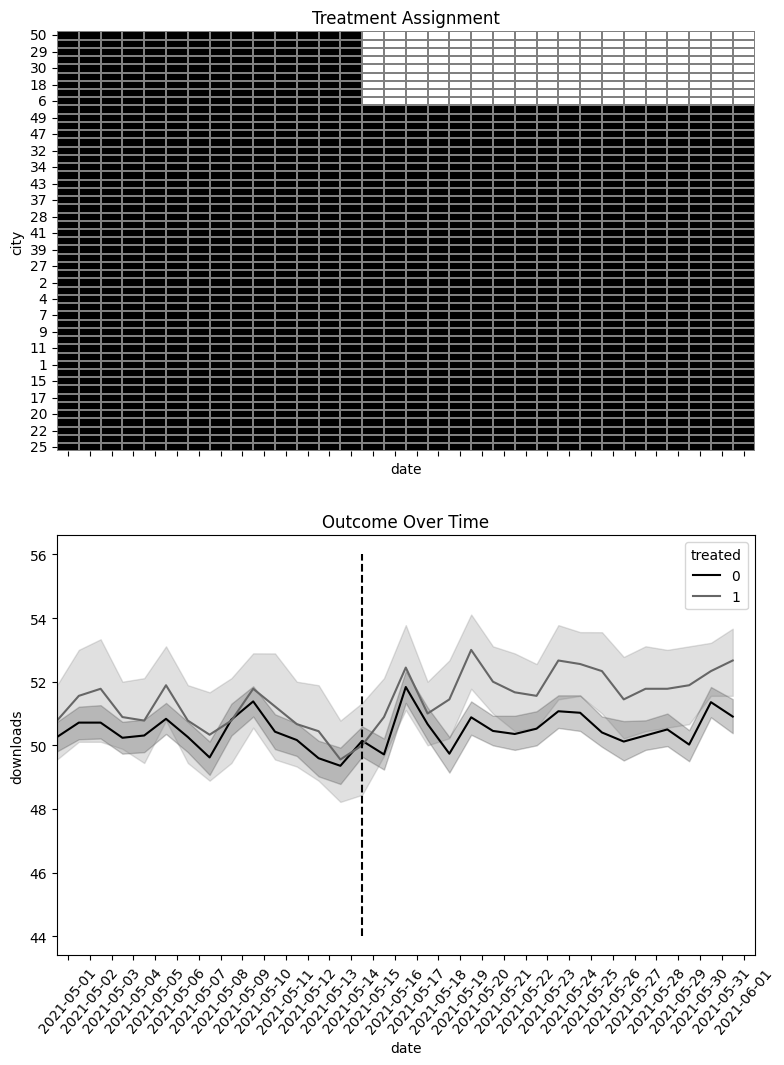

In [111]:
import matplotlib.ticker as pltticker 

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9,12), sharex=True)

heat_plt = (mkt_data
            .assign(treated=lambda d: d.groupby("city")["treated"].transform(max)) # treated / control group
            .astype({'date': 'str'})            # change from datetime64[ns] to string
            .assign(treated=mkt_data['treated']*mkt_data['post'])   # W = combination of period and grouping
            .pivot(index='city', columns='date', values='treated')   
            .reset_index()                      # make city index into a city column
            .sort_values(max(mkt_data['date'].astype(str)), ascending=False) # by pivot col '2021-06-01' 1,0
            .reset_index()                      # assign new index values, move old into column     
            .drop(columns=['city'])             # drop the city column, leaving date columns only
            .rename(columns={"index": "city"})  # due to previous city index, there are unique city rows
            .set_index("city"))                 # make the city column into the index for heatmap
            
sns.heatmap(heat_plt, cmap="gray", linewidth=0.01, linecolor="0.5", ax=ax1, cbar=False) # no color bar

ax1.set_title("Treatment Assignment")
  
sns.lineplot(data=mkt_data.astype({"date": "str"}), # average treated and control group downloads
             x="date", y="downloads", hue="treated", ax=ax2)   # average because argument estimator='mean'

loc=pltticker.MultipleLocator(base=2.0)
ax2.vlines("2021-05-15", mkt_data["downloads"].min(), mkt_data["downloads"].max(), color="black",
           ls="dashed", label="Interv.")
ax2.set_title("Outcome Over Time")
plt.xticks(rotation=50);   # suppress output of ticks with ;

In [114]:
# DID estimate with disaggregated data via regression against treated,post dummies and their interactions
m = smf.ols('downloads ~ treated*post', data=mkt_data).fit()
m.params["treated:post"]

0.6917359536407058

In [115]:
# DID estimate with disaggregated data via regression against fixed effect specification
m = smf.ols('downloads ~ treated:post + C(city) + C(date)', data=mkt_data).fit()
m.params["treated:post"]

0.6917359536406972

In [116]:
mkt_data.columns

Index(['date', 'city', 'region', 'treated', 'tau', 'downloads', 'post'], dtype='object')

In [117]:
(mkt_data
 .assign(w=lambda d: d["treated"]*d["post"]))["w"].mean() # portion of grid above (N·T) that was treated

0.09926470588235294

In [120]:
mkt_data.treated.mean()     # portion of units (N) that were treated

0.17647058823529413

#### Inference

The confidence intervals from regressing the outcome against fixed-effects or dummies with interactions is probably wrong. This is because you have N·T data points, but they are not independent and identically distributed, since the same unit appears multiple times. Treatment is assigned to the unit, not the time period, so sample size is actually N, not N·T, even though regression will use N·T when computing standard errors. Due to these issues, the standard errors from your regression are overly optimistic. To correct this overly optimistic standard errors, you can cluster the standard errors by unit. Clustering the errors will give you wider confidence intervals than no clustering at all. In fact when you replace the daily data frame with the one aggregated by unit and period, before clustering the errors by unit, the confidence interval gets even wider. This wider confidence interval is because more time periods per unit clusters was used. Some noncanonical flavors of DID won't have a standard way to compute confidence intervals, and in those situations, you can choose to bootstrap the entire estimation procedure. Since there are repeated units, the model's error for the same unit will be correlated. Hence, you need to sample (with replacement) the entire unit, a procedure called block bootstrap.

In [121]:
# ATT and its confidence interval using N data via clustering
m = smf.ols(
    'downloads ~ treated:post + C(city) + C(date)', data=mkt_data   # fixed effects
).fit(cov_type='cluster', cov_kwds={'groups': mkt_data['city']})    # cluster by city for error calculation

print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: 0.6917359536406972


0    0.296101
1    1.087370
Name: treated:post, dtype: float64

In [122]:
# ATT and its confidence interval using N·T data
m = smf.ols('downloads ~ treated:post + C(city) + C(date)', data=mkt_data).fit()
print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: 0.6917359536406972


0    0.478014
1    0.905457
Name: treated:post, dtype: float64

In [123]:
# ATT and its confidence interval using data aggregated by unit and pre- and post- treatment periods
m = smf.ols(
    'downloads ~ treated:post + C(city) + C(date)', data=did_data
).fit(cov_type='cluster', cov_kwds={'groups': did_data['city']})    # covariance should be clustered by city

print("ATT: ", m.params['treated:post'])
m.conf_int().loc['treated:post']

ATT:  0.6917359536407011


0    0.138188
1    1.245284
Name: treated:post, dtype: float64

In [125]:
did_data  # for each city, average outcome before and after treatment date (whether treated or control)

,city,post,downloads,date,treated
0,5,0,50.642857,2021-05-01,0
1,5,1,50.166667,2021-05-15,0
2,15,0,49.142857,2021-05-01,0
3,15,1,49.166667,2021-05-15,0
4,20,0,48.785714,2021-05-01,0
...,...,...,...,...,...
97,195,1,53.777778,2021-05-15,0
98,196,0,52.214286,2021-05-01,0
99,196,1,52.333333,2021-05-15,0
100,197,0,51.071429,2021-05-01,1


In [126]:
1.087370 - 0.296101

0.791269

In [127]:
0.905457 - 0.478014

0.42744299999999996

In [129]:
1.245284 - 0.138188


1.107096

In [136]:
def block_sample(df, unit_col):     # unit_col is the city column
    units = df[unit_col].unique()   # unique cities in the dataset, 51. Cities are integers 
    sample = np.random.choice(units, size=len(units), replace=True) # make 51 choices of cities with replacement

    return (df
            .set_index(unit_col)    # set the city column as the index 
            .loc[sample]            # sample cities 
            .reset_index(level=[unit_col]))

In [139]:
from joblib import Parallel, delayed 

def block_bootstrap(data, est_fn, unit_col, rounds=200, 
                    seed=123, pcts=[2.5, 97.5]):
    np.random.seed(seed)
    stats = Parallel(n_jobs=-1)(  # delayed decorator used to capture the arguments (here df) of a function
        delayed(est_fn)(block_sample(data, unit_col=unit_col)) for _ in range(rounds)) 
    return np.percentile(stats, pcts)  # 95% CI of att estimate

In [140]:
def est_fn(df): # regress outcome against fixed-effects
    m = smf.ols('downloads ~ treated:post + C(city) + C(date)', data=df).fit() 
    return m.params["treated:post"]  # return the att estimate

dblock_bootstrap(mkt_data, est_fn, "city")

array([0.23162214, 1.14002646])

#### DID Identification assumptions 

##### Parallel Trends 
The trajectory of outcomes across time would be the same, on average, for treatment and control groups, in the absence of the treatment. It assumes that the $Y(0)$ are parallel. This assumption is untestable because $E[Y(0)_{it=1}|D=1]$ is not observable, where $it=1$ is the post-treatment period and $it=0$ is the pre-treatment period.

$E[Y(0)_{it=1} - Y(0)_{it=0}|D=1]=E[Y(0)_{it=1}-Y(0)_{it=0}|D=0]$

In effect, while conditional independence assumption (CIA) for cross-sectional data states that the level of $Y(0)$ is the same for the treated and the control, parallel trends states that the growth of $Y(0)$ is the same between treated and control groups. 

$(\Delta y_0, \Delta y_1)⊥T$


#####  No anticipation and SUTVA

If parallel trends is the panel data version of CIA, then no anticipation is the panel data version of SUTVA. Stable unit of treatement value assumption states that there are no spillover effects across treatment and control units. No anticipation states that there is no spillover across time. SUTVA still applies if the units are geographic regions, since customers can move between geographic regions.


##### Strict Exogeneity

This basically says that the expectation of the residuals is 0. This is best expressed using the fixed effect model's residuals:

$Y_{it}=\alpha_i +X_{it}\beta+\epsilon_{it}$

$E[\epsilon_{it}|X_{it},\alpha_i]=0$

This assumption has three components: No Time-Varying Confounders, No Feedback, No carryover

- No Time-Varying Confounders: Repeated observations over time can identify the causal effect even if unobserved confounders are present, as long as such confounders are constant over time or units. For example, if the units are cities and each city has a different culture that affects behavior, the culture of the cities don't change before or after treatment, so any change in behavior can be attributed to the treatment. From a two-way fixed effects perspective, we can say that unit-fixed effects wipe out any variable that is constant over time. Similarly, time-fixed effects wipe out the effect of any variables that is constant across units. Again if the units are cities in the same country, then changes in the country's inflation or foreign exchange rates are constant across all units and any difference in behavior between the control and treatment cities is due to the treatment.

- No Feedback: No feedback means that treatment cannot be decided based on outcome trajectory. Suppose a marketing team decides to create an offline campaign in a city that reached a downloads reach say 1000 downloads, this would vioate the no feedback assumption.

- No carryover and no lagged dependent: This assumption means no carryover from past treatment to current outcomes. An related assumption is the no lagged dependent assumption which means that past outcomes do not affect current outcomes.The no carryover assumption can be relaxed by including lagged versions of the treatment. 

$\hspace{1 cm} Y_{it}=\tau_{it}W_{it} + \theta W_i{t-1} + \alpha_i + \gamma_t + \epsilon_{it}$






Text(0, 0.5, 'Log(y)')

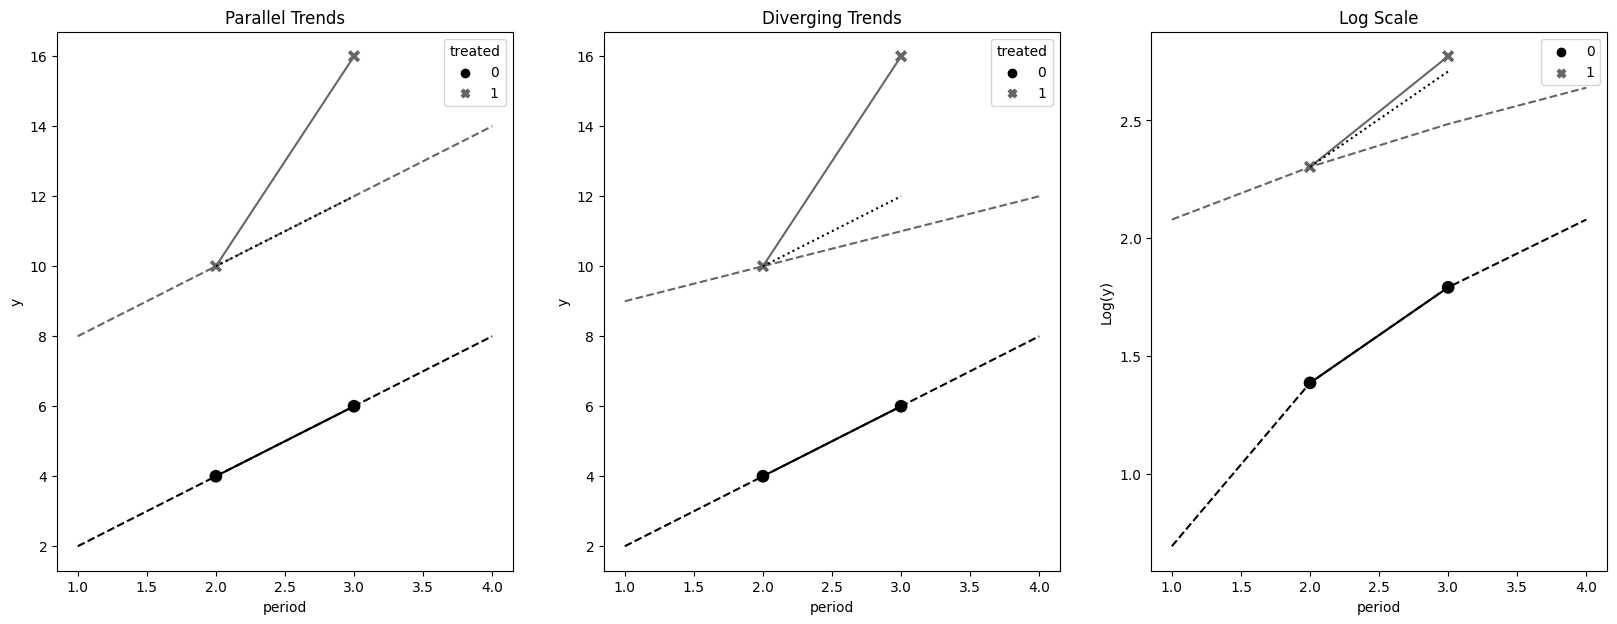

In [160]:
# Parallel Trends

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,7))

obs_df = pd.DataFrame(dict(
    period = [2,3,2,3],
    treated = [0,0,1,1],
    y = [4,6,10,16],
))                                                              # actual observation

#print(obs_df)

baseline = 10-4                                                 # treated(t=2) - control(t=2)

plt_d1 = pd.DataFrame(dict(
    period = [1,2,3,4,1,2,3,4],
    treated = [0,0,0,0,1,1,1,1],
    y = [2,4,6,8,8,10,12,14]
))                                                              # parallel trends assumptio

#print(plt_d1)

sns.lineplot(data=plt_d1, x="period", y="y", hue="treated", 
             linestyle="dashed", legend=None, ax=ax1)           # parallel trends assumption
sns.lineplot(data=obs_df, x="period", y="y", hue="treated", 
             legend=None, ax=ax1)                               # actual observation
sns.lineplot(data=obs_df.assign(y=obs_df["y"] + baseline).query("treated==0"),
             x="period", y="y", legend=None, ax=ax1, color="C0", linestyle="dotted")
sns.scatterplot(data=obs_df, x="period", y="y", hue="treated", 
                style="treated", s=100, ax=ax1)
ax1.set_title("Parallel Trends")



plt_d2 = pd.DataFrame(dict(
    period = [1,2,3,4,1,2,3,4],
    treated = [0,0,0,0,1,1,1,1],
    y = [2,4,6,8,9,10,11,12]
))

sns.lineplot(data=plt_d2, x="period", y="y", hue="treated", 
             linestyle="dashed", legend=None, ax=ax2)           # parallel trends assumption
sns.lineplot(data=obs_df, x="period", y="y", hue="treated", 
             legend=None, ax=ax2)                               # actual observation
sns.lineplot(data=obs_df.assign(y=obs_df["y"] + baseline).query("treated==0"),
             x="period", y="y", legend=None, ax=ax2, color="C0", linestyle="dotted")
sns.scatterplot(data=obs_df, x="period", y="y", hue="treated", 
                style="treated", s=100, ax=ax2)
ax2.set_title("Diverging Trends")

non_lin = np.log
non_lin_obs = obs_df.assign(y=non_lin(obs_df["y"]))

plt_d3 = pd.DataFrame(dict(
    period = [1,2,3,4,1,2,3,4],
    treated = [0,0,0,0,1,1,1,1],
    y = non_lin([2,4,6,8,8,10,12,14]),
))

sns.lineplot(data=plt_d3, x="period", y="y", hue="treated", linestyle="dashed", legend=None, ax=ax3)
sns.lineplot(data=non_lin_obs, x="period", y="y", hue="treated", legend=None, ax=ax3)
sns.scatterplot(data=non_lin_obs, x="period", y="y", hue="treated", style="treated", s=100, ax=ax3)
sns.lineplot(x=[2,3], y=non_lin_obs.query("treated==1 & period==2")["y"].values 
             - non_lin_obs.query("treated==0 & period==2")["y"].values
             + non_lin_obs.query("treated==0")["y"], color="C0", linestyle="dotted")
ax3.set_title("Log Scale")
ax3.set_ylabel("Log(y)")

#### Effect Dynamics over Time 

The difference between treated and control group doesn't increase right after the treatment takes place. It takes some time for the treatment to reach its full effect, ie treatment effect is not instantaneous. This means you might be underestimating the final treatment effect, because you are including periods where it hasn't fully matured yet. 

One way around this is to estimate ATT over time by iterating over all time periods, and running DID as if only that period was the post-treatment one. The function below, first filters only pre-treatment period and passed date. Next, it filters the dates equal to or before the passed date. If the passed date is from the post-treatment period, this filter is innocuous. If the date is from the pre-treatment period, it tosses away the dates after it. This allows to run DID even for the period before the treatment, because the function reassigns the post-treatment period to be the specified date. Now if you pass a date from the pre-treatment, the function will pretend that it comes from the post-treatment period, sort of a placebo test in the test dimension. Finally the function estimates a DID model, extracting the ATT and the confidence interval around it, and stores everything in a data frame. The function works for a single date, so to get the effect for all possible dates, iterate over them, getting the DID estimate each time. You have to skip the first date, as you need at least two time periods for DID to run.

A plot of the effect over time demonstrates that the effect doesnt climb after the treatment takes place. ATT is a bit higher if you discard the early periods, where it hasn't matured. Also, in the pre-treatment period, all estimated effects are indistinguishable from zero, which indicates that the effect does not occur prior to treatment, which is strong evidence that the no anticipation assumption may be valid in this case. 

In [191]:
def did_date(df, date):
    df_date = (df
               .query("date==@date | post==0")  # all pre-treatment dates and a single specified date
               .query("date <= @date")          # dates before or equal to specified date 
               .assign(post = lambda d: (d["date"] == date).astype(int))) # set specified date as treatment date
    
    m = smf.ols(
     "downloads ~ I(treated*post) + C(city) + C(date)", data=df_date # I() for python meaning here W=t*p
    ).fit(cov_type='cluster', cov_kwds={'groups': df_date['city']}) # cluster by unit for confidence interval

    att = m.params["I(treated * post)"]         # make sure to leave the space around *; treatment effect
    ci = m.conf_int().loc["I(treated * post)"]  # confidence interval of treatment dummy W=treated*post

    return pd.DataFrame({"att": att, "ci_low": ci[0], "ci_up": ci[1]}, index=[date]) # send df for concat

In [192]:
post_dates = sorted(mkt_data["date"].unique())[1:]  # all dates except first; need at least 2 dates for DID
atts = pd.concat([did_date(mkt_data, date) for date in post_dates]) # concatenate returned dataframes
atts.head()

,att,ci_low,ci_up
2021-05-02,0.325397,-0.491741,1.142534
2021-05-03,0.384921,-0.388389,1.158231
2021-05-04,-0.156085,-1.247491,0.935321
2021-05-05,-0.299603,-0.949935,0.350729
2021-05-06,0.347619,0.013115,0.682123


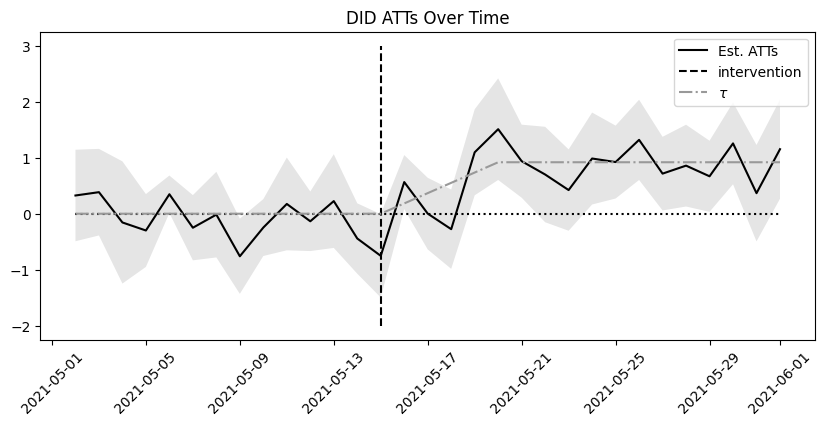

In [198]:
plt.figure(figsize=(10,4))
plt.plot(atts.index, atts["att"], label="Est. ATTs")  # att per date if each date was last treatment date

plt.fill_between(atts.index, atts["ci_low"], atts["ci_up"], alpha=0.1)

plt.vlines(pd.to_datetime("2021-05-15"), -2, 3, linestyle="dashed", label="intervention") #actual treatment date
plt.hlines(0, atts.index.min(), atts.index.max(), linestyle="dotted") # no change from intervention on date

plt.plot(atts.index, mkt_data.query("treated==1").groupby("date")[["tau"]].mean().values[1:],
         color="0.6", ls="-.", label="$\\tau$") # average att per date for treated units

plt.xticks(rotation=45)
plt.title("DID ATTs Over Time")
plt.legend()

#### Diff-in-Diff with Covariates
Including pre-treatment covariates in your model is useful in case you suspect that parallel trend doesn't hold but conditional parallel trend does. In otherwords, we condition based on whether a unit is treated / control as well as other identifying covariates, X, for the parallel trend to hold.

$E[Y(0)_{it=1} - Y(0)_{it=0}|D=1,X]=E[Y(0)_{it=1}-Y(0)_{it=0}|D=0,X]$

The data below is the same marketing data as before, but now we have data on multiple regions of the country. The pre-treatment trend seems to be parallel within a region, but not across regions. As a result, if you simply run two-way fixed effect specification of DID, you get a biased estimate for the ATT. Simply adding the region as an extra covariate does not solve the problem. The unit-fixed effects wipes out the effect of any time-fixed covariate including the region covariate, which is constant across time. So naively adding it to the regression gives the same biased estimate. To properly include pre-treatment covariates in your DID model, recall that DID works by estimating two important pieces: the treated baseline and the control trend. It then projects the control trend into the treated baseline. This means you have to estimate the control trend for each region separately. You can loop through the regions  and run separate difference-in-differences or interact the entire DID model with region dummies.

In [202]:
mkt_data_all = (pd.read_csv("data/short_offline_mkt_all_regions.csv").astype({"date": "datetime64[ns]"}))
mkt_data_all.head()

,date,city,region,treated,tau,downloads,post
0,2021-05-01,1,W,0,0.0,27.0,0
1,2021-05-02,1,W,0,0.0,28.0,0
2,2021-05-03,1,W,0,0.0,28.0,0
3,2021-05-04,1,W,0,0.0,26.0,0
4,2021-05-05,1,W,0,0.0,28.0,0


In [204]:
print(mkt_data_all.shape)

(6400, 7)


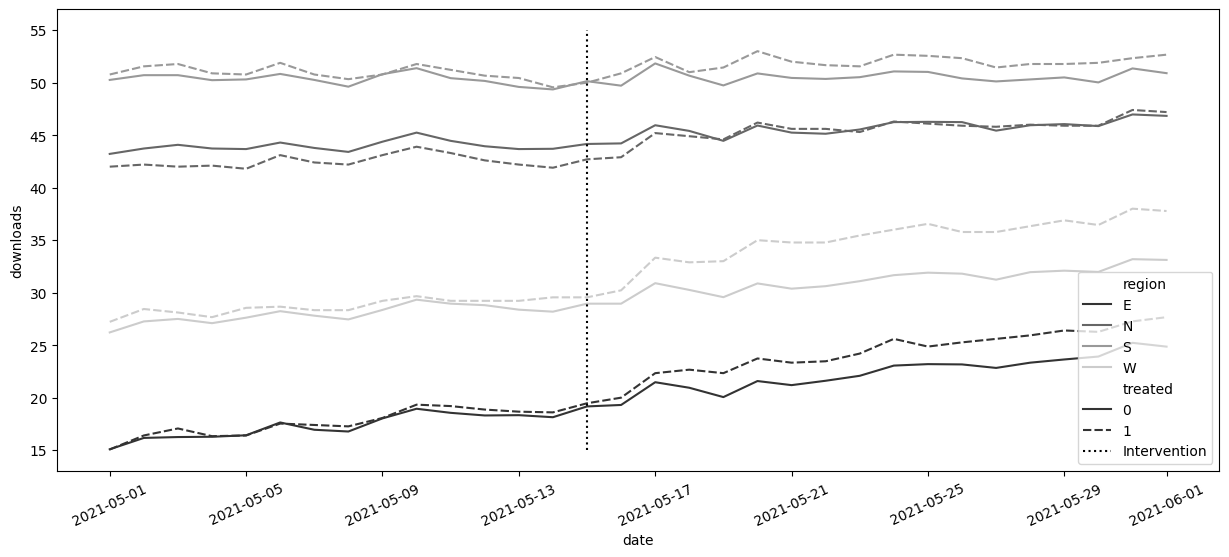

In [206]:
# average downloads for treated / control against date for each region
plt.figure(figsize=(15,6))
sns.lineplot(data=mkt_data_all.groupby(["date", "region", "treated"])[["downloads"]].mean().reset_index(),
             x="date", y="downloads", hue="region", style="treated", palette="gray")
plt.vlines(pd.to_datetime("2021-05-15"), 15, 55, ls="dotted", label="Intervention")
plt.legend()
plt.xticks(rotation=25);

In [207]:
# Two-way fixed effects regression
print("True ATT: ", mkt_data_all.query("treated*post==1")["tau"].mean()) # true att

m = smf.ols("downloads ~ treated*post + C(city) + C(date)", data=mkt_data_all).fit()
print("Estimated ATT: ", m.params["treated:post"]) # att by fixed-effects regression

True ATT:  1.7208921056102682
Estimated ATT:  2.0678725729175076


In [208]:
# Including covariate in regression
m = smf.ols("downloads ~ treated: post + C(city) + C(date) + C(region)", 
            data=mkt_data_all).fit()
m.params["treated:post"]  # att by including covariate (region) in

2.0684967347693237

In [209]:
# Properly include region covariates (estimate treated*post for each regions)
m_saturated = smf.ols('downloads ~ (post*treated)*C(region)', data=mkt_data_all).fit()
atts = m_saturated.params[m_saturated.params.index.str.contains("post:treated")]
atts

post:treated                   1.676808
post:treated:C(region)[T.N]   -0.343667
post:treated:C(region)[T.S]   -0.985072
post:treated:C(region)[T.W]    1.369363
dtype: float64

ATT estimate should be interpreted with respect to the baseline group, which is the East region (the dropout). So the effect on the North region is 1.67 - 0.34, the effect on the South region is 1.67 - 0.98, and so on. Next, aggregate the different ATTs using a weighted average, where the number of cities in a region is the weight.

This approach is easy to understand, but not perfect. If you have many covariates or a continuous covariate, this approach will become impractical. There is another way. Instead of interacting the region with post and treatment dummies, you can interact the post dummy alone. This model will estimate the trend (pre- and post-outcome levels) for the treated in each region separately, but will fit a single intercept shift to the treated and post period.
This way, the parameter associated with post:treated can be interpreted as the ATT. It is not exactly the same ATT as before, though pretty close. The difference is because regression averages the regions ATT by variance, instead of by region size, meaning, regression will overweight regions where treatment is more evenly distributed (has higher variance). This approach requires careful thinking on how to do the interactions. Below we use post(treated + C(regions)), so we get interactions with post and treated as well as post and the regions. Alternatively, you could build a DID model for each region and average the results.

In [210]:

reg_size = (mkt_data_all.groupby("region").size() /     # unique cities in each region (records / dates)
            len(mkt_data_all["date"].unique()))         # mkt_data_all.groupby('region')['city'].nunique()
base = atts[0]                                          # average or base ATT

In [211]:
# the ATT contributions of all regions
np.array([reg_size[0]*base]         # E has a contribution equal to the average or base ATT
         + [(att+base)*size for att, size in zip(atts[1:], reg_size[1:])] # regional contributions
         ).sum()/sum(reg_size)

1.6940400451471271

In [222]:
# Interacting the region with the post dummy alone
m = smf.ols('downloads ~ post*(treated + C(region))', data=mkt_data_all).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.3522,0.101,172.218,0.000,17.155,17.550
C(region)[T.N],26.2770,0.137,191.739,0.000,26.008,26.546
C(region)[T.S],33.0815,0.135,245.772,0.000,32.818,33.345
C(region)[T.W],10.7118,0.135,79.581,0.000,10.448,10.976
post,4.9807,0.134,37.074,0.000,4.717,5.244
post:C(region)[T.N],-3.3458,0.183,-18.310,0.000,-3.704,-2.988
post:C(region)[T.S],-4.9334,0.179,-27.489,0.000,-5.285,-4.582
post:C(region)[T.W],-1.5408,0.179,-8.585,0.000,-1.893,-1.189
treated,0.0503,0.117,0.429,0.668,-0.179,0.280
post:treated,1.6811,0.156,10.758,0.000,1.375,1.987


#### Doubly Robust Diff-in-Diff

Another way of incorporating pre-treatment and time invariant covariates is to allow for conditionally parallel trends by making a doubly robust version of difference-in-differences (DRDID). First, instead of having a raw outcome model, since DID works with $\Delta y$ (difference between the average outcome at the pre- and post-treatment periods), you need a model for the delta outcome over time (panel data version of doubly robust outcome model). Second, because you only care about ATT, you only need to reconstruct treated population from control units (panel data version of doubly robust treatment assignment model).

The first step in DRDID is a propensity score model $\hat e(X)$ that uses pre-treatment covariates to estimate the probability that a unit comes from the treated group. This model doesn't care about time dimension, which means you only need one period worth of data to estimate it. In our example data, the logistic regression model will predict the treated column as function of the region column.

In [239]:
# propensity score model
unit_df = (mkt_data_all
           # keep only the first date
           .astype({'date': str})
           .query(f"date=='{mkt_data_all['date'].astype(str).min()}'") # earliest pre-treatment date only
           .drop(columns=["date"]) # just to avoid confusion
           )
ps_model = smf.logit("treated~C(region)", data=unit_df).fit(disp=0)  # logistic regression P(T|X)

Next, you need the outcome model for $\Delta y$, which means that you need to construct the delta outcome data. You need to take the difference between the average outcome at the pre- and post-treatment periods, leaving one row for each unit, since the time dimension has been differentiated out. Next, you join $\Delta y$ data to the columns of the unit dataset (with the covariates for a specific date) and fit the outcome model in it. In the example data, the ols model will predict the $\Delta y$ column as a function of the region column.

In [240]:
# Delta Outcome Model
delta_y = (
    mkt_data_all.query("post==1").groupby("city")["downloads"].mean()   # mean post-treatment outcome per unit
    - mkt_data_all.query("post==0").groupby("city")["downloads"].mean() # mean pre-treatment outcome per unit
)

df_delta_y = (unit_df               # data frame containing the time-invariant covariates, X (here region)
              .set_index("city")    # join unit_df to delta_y series on the city index
              .join(delta_y.rename("delta_y"))) # Series from previous groupby has city as index
outcome_model = smf.ols("delta_y ~ C(region)", data=df_delta_y).fit() # linear regression (Δy = f(X))

For the final estimator, you'll need the actual $\Delta y$, the propensity score, and the predicted $\Delta y$. To do that below, you can start from the delta y dataframe (with unit-level covariates) used to build the outcome model and make predictions using both propensity score model, $\hat e(x)$, and the outcome model, $\hat m(x)$, the result being a unit-level dataframe.

In [243]:
df_dr = (df_delta_y     # unit-level covariates, and actual Δy
         .assign(y_hat = lambda d: outcome_model.predict(d))    # unit-level predicted Δy from covariates
         .assign(ps = lambda d: ps_model.predict(d)))           # unit-level P(T|X) from covariates

In [244]:
df_dr.head()

,region,treated,tau,downloads,post,delta_y,y_hat,ps
city,,,,,,,,
1,W,0,0.0,27.0,0,3.087302,3.736539,0.176471
2,N,0,0.0,40.0,0,1.436508,1.992570,0.212766
3,W,0,0.0,30.0,0,2.761905,3.736539,0.176471
4,W,0,0.0,26.0,0,3.396825,3.736539,0.176471
5,S,0,0.0,51.0,0,-0.476190,0.343915,0.176471


The ATT estimate is the difference between the trend, had the units been treated, from the trend they would have under the control. These are counterfactual quantities, $\Delta y_1$ and $\Delta y_0$ respectively.

$\hat \tau _{DRDID} = \widehat {\Delta y}_1^{DR} - \widehat {\Delta y}_0^{DR}$

To estimate the treated counterfactual $\Delta y_1$ (average difference in pre- and post-treatment periods for treated), you would weight $y-\widehat m(x)$ by the inverse of the propensity score, which would reconstruct $y_1$ for the entire population. Since you only care about the ATT, you don't need that since you already got the treatment population. Hence the first term becomes:

$ \widehat {\Delta y}_1^{DR} = 1/N_{tr}\;\Sigma_{i\; \epsilon \;tr}(\Delta y - \widehat m(X))$

For the other term $\Delta y_0$ (average difference in pre- and post-treatment periods for control), you would use weights $1/(1-\hat e(x))$ to reconstruct the general population under the control. Since you care about the ATT, you need to reconstruct the treatment population under the control, simply by multiplying the weights by chance of being a treated unit, which is the propensity score:

$w_{co}=\hat e(X) \frac{1}{1-\hat e(X)}$

$\widehat{\Delta y}_0^{DR} = \Sigma _ {i\;\epsilon\;co} w_{co}(\Delta y - \widehat m(X))/\Sigma w_{co}$

To get confidence intervals for DRDID, you need to use block bootstrap function.

In [245]:
tr = df_dr.query("treated==1")                          # the treated group
co = df_dr.query("treated==0")                          # the control group

dy1_treat = (tr["delta_y"] - tr["y_hat"]).mean()        # average deviation, actual and predicted Δy treated

w_cont = co["ps"]/(1-co["ps"])                          # control weights, propensity by inverse prob of control
dy0_treat = np.average(co["delta_y"] - co["y_hat"], weights=w_cont) # weighted average deviation, Δy control

print("ATT: " , dy1_treat - dy0_treat)

ATT:  1.6773180394442855


#### Staggered Adoption 

In block design, there are only two periods, pre- and post- treatment periods. Each period has multiple dates but you had a group of units that were all treated at the same point in time and a group of units that were never treated. Block design in difference-in-differences analysis, keeps things extremely simple, allowing you to estimate baselines and trends nonparametrically, by simply computing a bunch of averages and comparing them. But, what if treatment gets rolled out to the units at different points in time?

A more common situation with panel data is staggered adoption design, where you have multiple groups of units, $G$, and each group gets treated at a different point in time (or never). Timing of treatment defines a group, so groups are called cohorts and a group $G$ that gets treatment at time $t$ is the cohort $G_t$. The block design marketing data we've been using so far has two cohorts, a never treated cohort or $G_{\infty}$, and a group that got the treatment at 2021-05-15, or $G_{15/05}$. For the staggered adoption design, we use a dataset that includes what happens after 2021-06-01 until 2021-07-31. Now we have four different cohorts, three of which are treated, and a never treated group (which has a cohort date of 2100-01-01 in this dataset). 

Note that in both block design and staggered adoption, you assume that once the treatment turns on, it stays that way forever. This assumption keeps things tractable. This is because in panel data analysis, potential outcomes are defined by vectors representing the trajectory of the outcome at each time period, $D=(Y_{d1}, Y_{d2}, ..., Y_{dT})$, and the treatment effect is defined by contrasting two of these trajectories. This means there are $2^{T}$ ways to define the treatment effect if you allow the treatment to turn on and off.

In [249]:
mkt_data_cohorts = (pd.read_csv("data/offline_mkt_staggered.csv")
                    .astype({
                        "date": "datetime64[ns]",       # set the date and cohort columns as dates not strings
                        "cohort": "datetime64[ns]"
                    }))
mkt_data_cohorts.head()

,date,city,region,cohort,treated,tau,downloads,post
0,2021-05-01,1,W,2021-06-20,1,0.0,27.0,0
1,2021-05-02,1,W,2021-06-20,1,0.0,28.0,0
2,2021-05-03,1,W,2021-06-20,1,0.0,28.0,0
3,2021-05-04,1,W,2021-06-20,1,0.0,26.0,0
4,2021-05-05,1,W,2021-06-20,1,0.0,28.0,0


Text(35, 170, 'Cohort$=G_{\\infty}$')

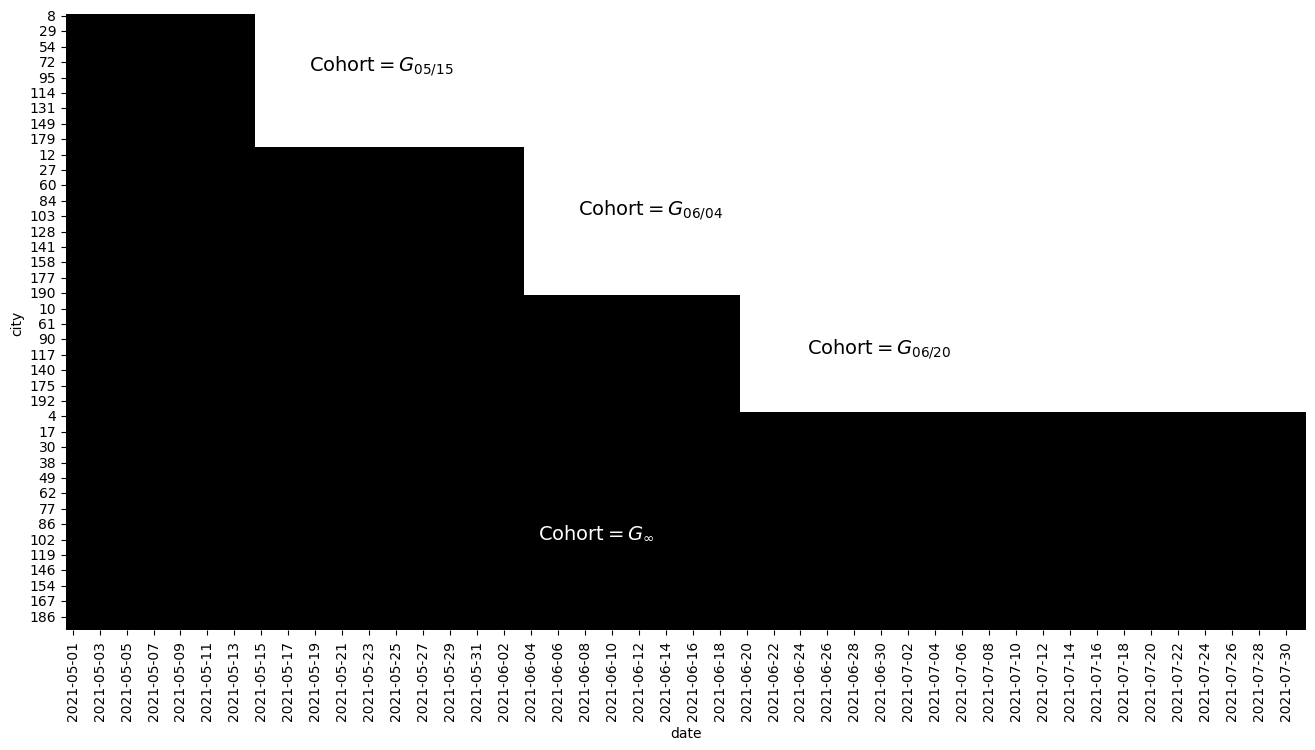

In [285]:
plt_data = (mkt_data_cohorts
            .astype({"date": "str"})
            .assign(treated_post=lambda d: # unit was treated if in treated group and date is after cohort date
                    d["treated"] * (d["date"]>=d["cohort"])) # d['post'] is equal to d['date']>=d['cohort']
            .pivot(index="city", columns="date", values="treated_post") # pivot cohort dates as columns
            .reset_index() # make the city index a column
            .sort_values(list(sorted(mkt_data_cohorts   # filter out control and sort rows into cohorts
                                     .query("cohort!='2100-01-01'")["cohort"].astype("str").unique())),
                                     ascending=False) # cohorts have treated_post values of 1; others 0
            .reset_index()              # reset index after query and sort_values filters and reorders rows
            .drop(columns=["city"])     # drop city column from pivot
            .rename(columns={"index":"city"})   # make reset index column the city column since unique
            .set_index("city"))                 # make new city column the index
            
            

plt.figure(figsize=(16,8))

sns.heatmap(plt_data, cmap="gray", cbar=False)
plt.text(18, 18, "Cohort$=G_{05/15}$", size=14)
plt.text(38, 65, "Cohort$=G_{06/04}$", size=14)
plt.text(55, 110, "Cohort$=G_{06/20}$", size=14)
plt.text(35, 170, "Cohort$=G_{\\infty}$", color="white", size=14, weight=3)


In the plots below, we look specifically at one region, the West region, thus neglecting covariates. The plots represent the average downloads over time for each cohort in the West region. The first plot shows an increase after the treatment date for each cohort. Meanwhile, the group that was never treated follows a parallel trend to the treated groups prior to the treatment. Also, the effect takes some time to mature, as is evidenced in the second plot, whee the outcome is aligned for the cohort, not by date but rather by days to or from treatment. After treatment (days_to_treatment == 0), it takes some time for the new trajectory of the average downloads to be stabilized.

In [297]:
# Focus on just the West region
mkt_data_cohorts_w = mkt_data_cohorts.query("region=='W'")
mkt_data_cohorts_w.head()

,date,city,region,cohort,treated,tau,downloads,post
0,2021-05-01,1,W,2021-06-20,1,0.0,27.0,0
1,2021-05-02,1,W,2021-06-20,1,0.0,28.0,0
2,2021-05-03,1,W,2021-06-20,1,0.0,28.0,0
3,2021-05-04,1,W,2021-06-20,1,0.0,26.0,0
4,2021-05-05,1,W,2021-06-20,1,0.0,28.0,0


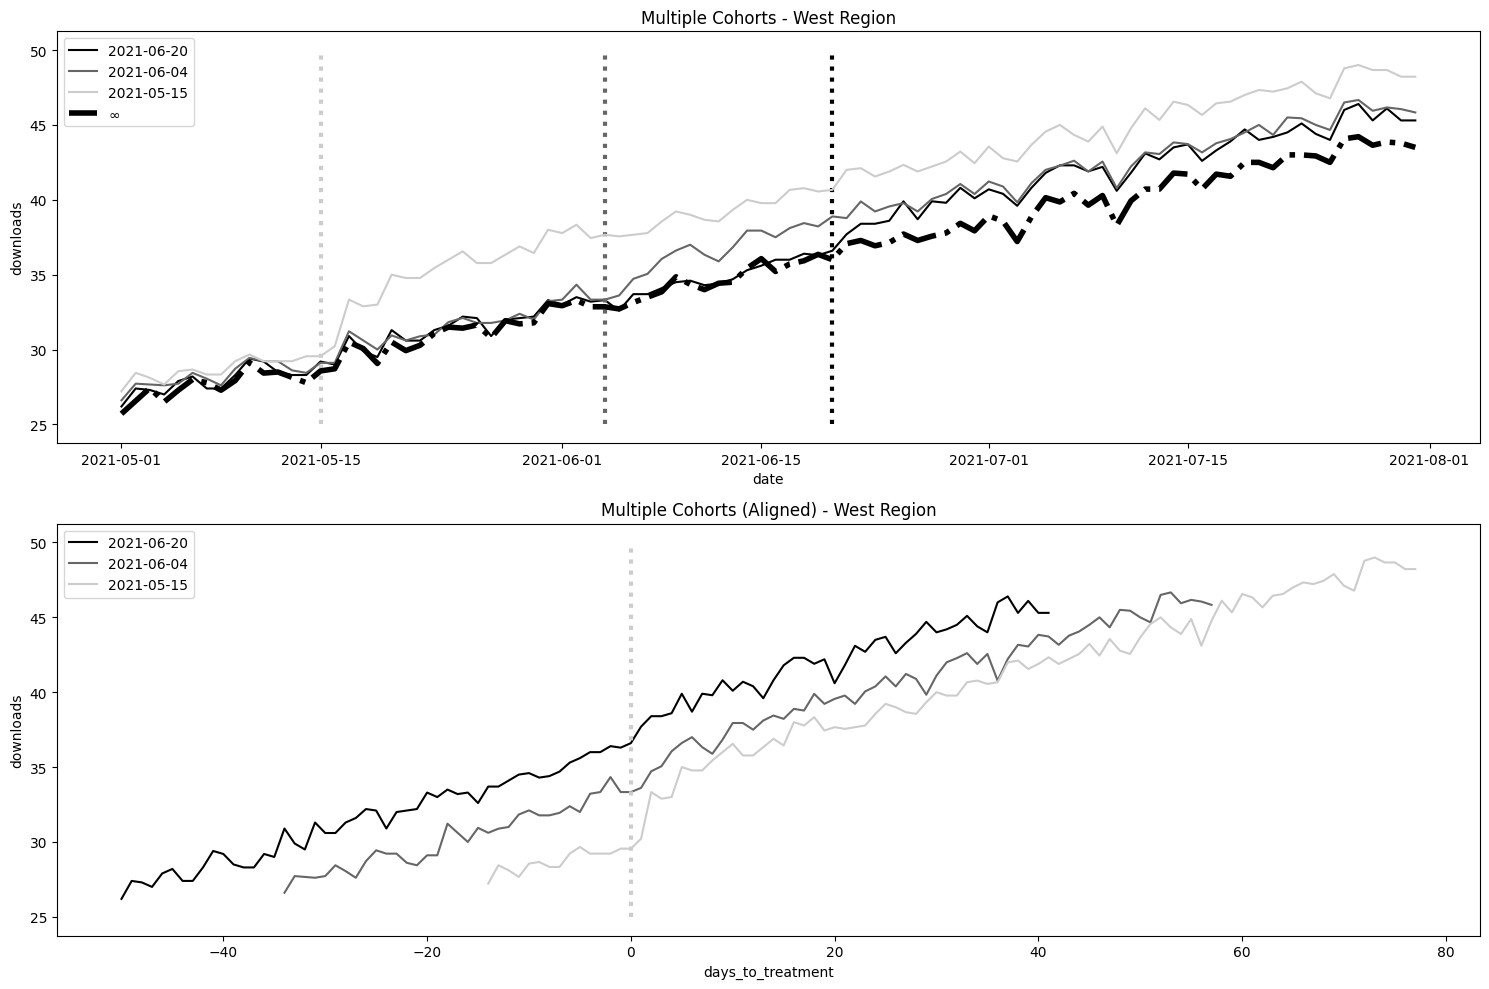

In [302]:
# average downloads over time for each cohort
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))

plt_data = (mkt_data_cohorts_w
            .groupby(["date", "cohort"]) # 'date' will be the common x-axis, 'cohort' will be hue
            [["downloads"]]     
            .mean()             # average downloads (outcome) across dates for each cohort
            .reset_index()      # make date and cohort into columns instead of
)

for color, cohort in zip(["C0", "C1", "C2", "C3"],  # unique cohorts except the never treated
                         mkt_data_cohorts_w.query("cohort!='2100-01-01'")["cohort"].unique()):
    df_cohort = plt_data.query("cohort==@cohort")   # use @ to refer to cohort variable in .query()
    sns.lineplot(data=df_cohort, x="date", y="downloads", # cohort line plot
                 label=pd.to_datetime(cohort).strftime('%Y-%m-%d'), ax=ax1) # str to daterime for strftime use
    ax1.vlines(x=cohort, ymin=25, ymax=50, color=color, ls="dotted", lw=3)  # treatment date of cohort

sns.lineplot(data=plt_data.query("cohort=='2100-01-01'"), x="date", y="downloads", 
             label="$\infty$", lw=4, ls="-.", ax=ax1)   # line plot for never treated cohort (control)

ax1.legend()
ax1.set_title("Multiple Cohorts - West Region")


plt_data = (mkt_data_cohorts_w
            .assign(days_to_treatment = 
                    lambda d: (pd.to_datetime(d["date"]) # days from treatment (neg before treatment, pos after)
                             - pd.to_datetime(d["cohort"])).dt.days) # datetime accessor for diff. in days
            .groupby(["date", "cohort"])            # date is common x-axis value, cohort is hue
            [["downloads", "days_to_treatment"]]    
            .mean()                                 # average downloads, average days to treatment
            .reset_index())                         # make date and cohort into columns from index

for color, cohort in zip(["C0", "C1", "C2", "C3"],  # unique cohorts except the never treated
                         mkt_data_cohorts_w.query("cohort!='2100-01-01'")["cohort"].unique()):
    df_cohort = plt_data.query("cohort==@cohort")   # use @ to refer to cohort variable in .query()
    sns.lineplot(data=df_cohort, x="days_to_treatment", y="downloads",
                 label=pd.to_datetime(cohort).strftime('%Y-%m-%d'), ax=ax2) # cohort line plot
    
ax2.vlines(x=0, ymin=25, ymax=50, color=color, ls="dotted", lw=3)  # treatment date of cohort
ax2.legend()
ax2.set_title("Multiple Cohorts (Aligned) - West Region")

plt.tight_layout()

Since the data is simulated, we have access to the true effect. Again considering only the west region, we use difference-in-difference with fixed effect to find treatment effect. Surprisingly we are unable to recover the true ATT. In fact, the effect seems downward biased. The root of this problem lies in the fact that for staggered adoption, in addition to the traditional DID assuptions, you also need to assume that effects are homogeneous across time, which is not the case in this dataset. As seen in the aligned plot of average outcome over time from treatment, the effect takes some time to mature, meaning the effect is lower just after the treatment and gradually climbs up afterward. This effect change over time causes bias in ATT estimate.

Take two groups of cities in the dataset, the first group which is the early treated cohort, received treatment on 06/04, while the second group which is the late treated cohort received treatment on 06/20. The two-way fixed-effect model, uses a series of 2x2 diff-in-diff runs and combines them into a final estimate. The model estimates the effect of treatment on the early treated cohort using the late treated group as a control. This is valid because the late treated cohort can be considered a not-yet-treated group. However, the model is also estimating the effect on the late treated cohort by using the early treated cohort as a control. This approach is acceptable, but only if the treatment effect is not variable across time.

Early versus late comparison seems fine. The issue is on the late versus early. The control group (cohort 06/04) is
already treated, even though it serves as control here. Moreover, since effect is heterogeneous, gradually climbing up, trend in the control (early treated) is steeper than it would be, had the cohort not yet been treated. This extra steepness from the gradually increasing effect causes an overestimate in the control trend, which in turn translates to a downward-biased ATT estimate. This is why the already treated as a control will bias your results if the treatment effect is heterogeneous across time.

In [307]:
# diff-in-diff with fixed effects for west region
twfe_model = smf.ols(
    "downloads ~ treated:post + C(date) + C(city)",     
    data = mkt_data_cohorts_w
).fit()   # time fixed and unit fixed effects with treatment variable

true_tau = mkt_data_cohorts_w.query("post==1 & treated==1")["tau"].mean()  # att

print("True Effect: ", true_tau)
print("Estimated ATT: ", twfe_model.params["treated:post"])  # true effect is underestimated

True Effect:  2.2625252108176266
Estimated ATT:  1.7599504780633768


Estimated Effect, Early vs Late:  1.5373366013071872
True Effect, Early vs Late:  1.4885686653668804
Estimated Effect, Late vs Early :  1.4051851851852062
True Effect, Late vs Early :  1.4975298454383408


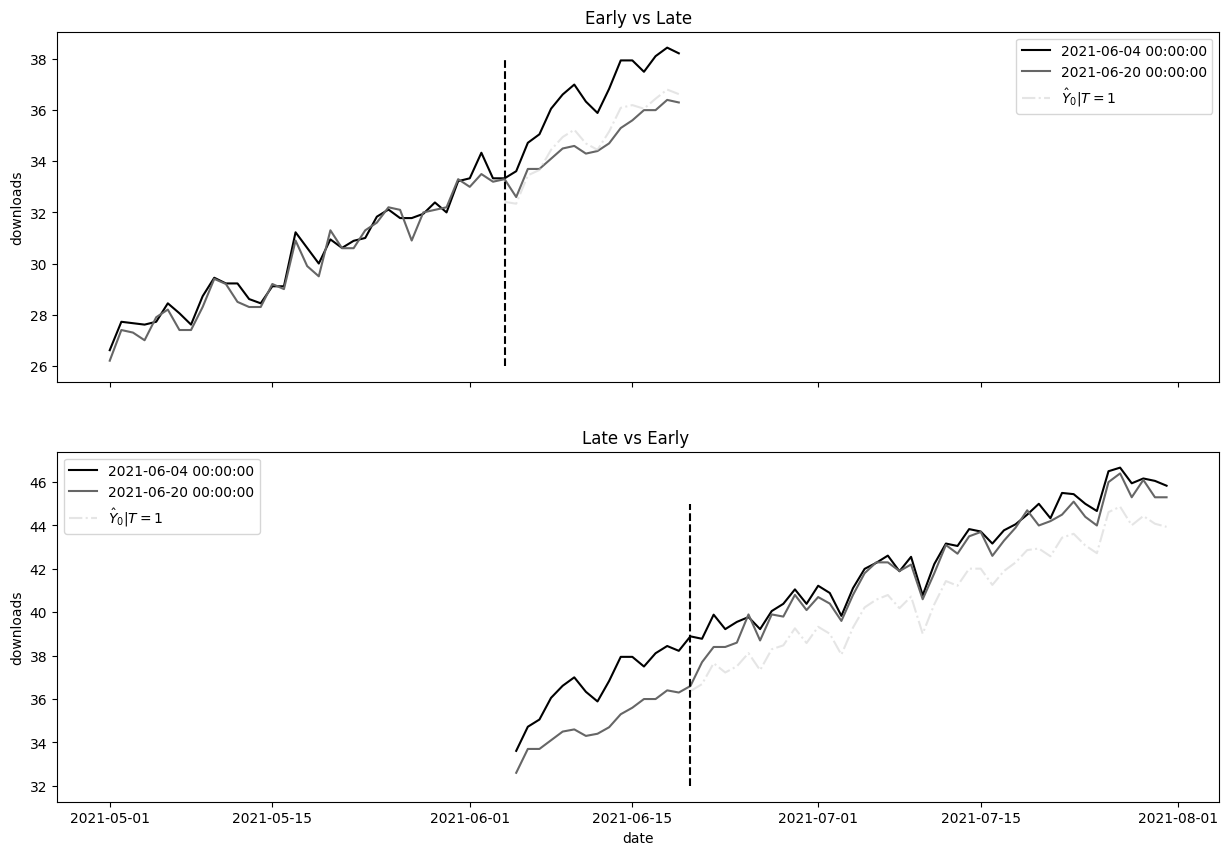

In [319]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10), sharex=True)

cohort_erly = '2021-06-04'
cohort_late = '2021-06-20'

# Early vs Late
did_df = (mkt_data_cohorts_w
          .loc[lambda d: d["date"].astype(str) < cohort_late] # considering records up to late cohort date
          .query(f"cohort=='{cohort_late}'| cohort=='{cohort_erly}'")   # treament date of early / late cohort
          .assign(treated = lambda d: (d["cohort"] == cohort_erly)*1,   # early cohort treated group dummy 
                  post = lambda d: (d["date"].astype(str) >= cohort_erly)*1)# early cohort post-treatment dummy
          )                                                                 # *1 to convert from bool to int    

m = smf.ols("downloads ~ treated:post + C(date) + C(city)",data=did_df).fit()# two-way fixed-effect model

print("Estimated Effect, Early vs Late: ", m.params["treated:post"]) # predicted regression treatment effect
print("True Effect, Early vs Late: ", did_df.query( # treated group, post-treatment actual treatment effect
                                        "post==1 & treated==1")["tau"].mean()) 


plt_data = (did_df
            .assign(installs_hat_0=lambda d: m.predict(d.assign(treated=0))) # projected control trend
            .groupby(["date", "cohort"])    # date is the x-axis , cohort is the hue
            [["downloads", "post", "treated", "installs_hat_0"]] 
            .mean()     # mean actual outcome, post, treated group, potential outcome (estimated counterfactual)
            .reset_index())

sns.lineplot(data=plt_data, x="date", y="downloads", hue="cohort", ax=ax1) # outcome over time (early vs late)
sns.lineplot(data=plt_data.query("treated==1 & post==1"),   # treated group, post treatment date
             x="date", y="installs_hat_0", ax=ax1, ls="-.", # projected controls trend      
             alpha=0.5, label="$\hat{Y}_0|T=1$")
ax1.vlines(pd.to_datetime(cohort_erly), 26, 38, ls="dashed")    # treatment date
ax1.legend()
ax1.set_title("Early vs Late")

# Late vs Early 
did_df = (mkt_data_cohorts_w
          .loc[lambda d: d["date"].astype(str) > cohort_erly] # considering records after early cohort date
          .query(f"cohort=='{cohort_late}'| cohort=='{cohort_erly}'")   # treament date of early / late cohort
          .assign(treated = lambda d: (d["cohort"] == cohort_late)*1,   # late cohort treated group dummy 
                  post = lambda d: (d["date"].astype(str) >= cohort_late)*1)# late cohort post-treatment dummy
          )

m = smf.ols("downloads ~ treated:post + C(date) + C(city)",data=did_df).fit()   # two-way fixed-effect model

print("Estimated Effect, Late vs Early : ", m.params["treated:post"])
print("True Effect, Late vs Early : ", did_df.query(    # treated group, post-treatment actual treatment effect
                                        "post==1 & treated==1")["tau"].mean())


plt_data = (did_df
            .assign(installs_hat_0=lambda d: m.predict(d.assign(treated=0)))    # projected control trend
            .groupby(["date", "cohort"])        # date is the x-axis , cohort is the hue
            [["downloads", "post", "treated", "installs_hat_0"]] 
            .mean()     # mean actual outcome, post, treated group, potential outcome (estimated counterfactual)
            .reset_index())

sns.lineplot(data=plt_data, x="date", y="downloads", hue="cohort", ax=ax2) # outcome over time (late vs early)
sns.lineplot(data=plt_data.query("treated==1 & post==1"),       # treated group, post treatment date
             x="date", y="installs_hat_0", ax=ax2, ls="-.",     # estimated counterfactual Y_0 trend
             alpha=0.5, label="$\hat{Y}_0|T=1$")
ax2.vlines(pd.to_datetime(cohort_late), 32, 45, ls="dashed")
ax2.legend()
ax2.set_title("Late vs Early ");

#### Heterogeneous Effect over Time

Two-way fixed effect (TWFE) is biased when applied to staggered adoption data that has time-heterogeneous effects. That is, the data generating process has different effect parameters

$Y_{it}=\tau _{it}W_{it} + \alpha_i + \gamma_t + e_{it}$

while we were assuming the effect was constant :

$Y_{it}=\tau W_{it} + \alpha_i + \gamma_t + e_{it}$

If that is the problem, an easy fix would be to simply allow for a different effect for each time and unit. Using something like:

$downloads\;$~$\;treated:post:C(date):C(city) + C(date) + C(city) \;$

Problem is, this model would have more parameters than there are data points. By interacting date and unit, you would have one treatment effect parameter for each unit for each time period. That is the number of samples you have. OLS wouldn't even run here. So we need to reduce the number of treatment effect parameters of the model. We can do this by grouping the units. A natural way to group units is by cohort. This is intuitive because the effect in an entire cohort follows the same pattern over time. So we allow the effect to change by cohort instead of by units. This model has a more reasonable number of treatment effect parameters since number of cohorts is usually much smaller than number of units:

$Y_{it}=\tau_{gt}W_{it} + \alpha_i + \gamma_t + e_{it}$

$downloads\;$~$\;treated:post:C(cohort):C(date) + C(city)\;+ C(date) $

This will give multiple ATT estimates: one for each cohort and date. You can compute estimated individual treatment effect implied by your model and average out the result. To do that, just compare the actual outcome at the post-treatment period from the treated units with what your models predict for $\hat y_0$.

In [320]:
formula = "downloads ~ treated:post:C(cohort):C(date) + C(city)+C(date)" # interactions for cohort and date
twfe_model = smf.ols(formula, data=mkt_data_cohorts_w).fit() # heterogenous effect over time

In [330]:
# calculate the ATT
df_pred = (mkt_data_cohorts_w
           .query("post==1&treated==1") # filter only treated units ie in treated group, after post-intervention
           .assign(y_hat_0=lambda d: twfe_model.predict(d.assign(treated=0))) # treated=0, pred potential Y_0
           .assign(effect_hat=lambda d: d["downloads"] - d["y_hat_0"])  # individual effect, treated units
           )

print("Number of param.: ", len(twfe_model.params))         # number of model parameters
print("True Effect: ", df_pred["tau"].mean())               # average treatment effect
print("Predicted Effect: ", df_pred["effect_hat"].mean())   # average treatment effect

Number of param.:  510
True Effect:  2.2625252108176266
Predicted Effect:  2.25976614468501


In [340]:
mkt_data_cohorts_w.treated.nunique()

2

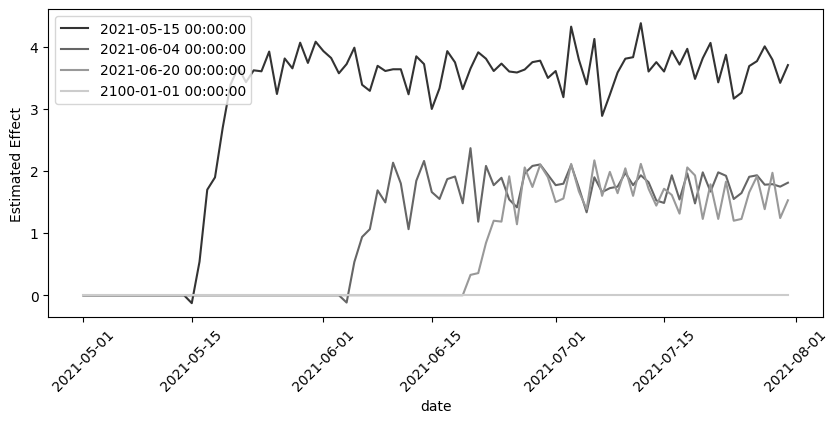

In [343]:
formula = "downloads ~ treated:post:C(cohort):C(date) + C(city) + C(date)"

twfe_model = smf.ols(formula, data=mkt_data_cohorts_w.astype({"date": str, "cohort":str})).fit()

effects = (twfe_model.params[twfe_model.params.index.str.contains("treated")] # filter rows with interactions
           .reset_index() # make the interaction variable a column, so you have two columns
           .rename(columns={0:"param"}) # rename variable coefficient column
           .assign(cohort=lambda d: d["index"].str.extract(r'C\(cohort\)\[(.*)\]:')) # reg exp extract cohort
           .assign(date=lambda d: d["index"].str.extract(r':C\(date\)\[(.*)\]'))     # reg exp extract date 
           .assign(date=lambda d: pd.to_datetime(d["date"]),            # convert date to datetime object
                   cohort=lambda d: pd.to_datetime(d["cohort"])))       # convert cohort to datetime object

plt.figure(figsize=(10,4))
sns.lineplot(data=effects, x="date", y="param", hue="cohort", palette="gray")
plt.xticks(rotation=45)
plt.ylabel("Estimated Effect")
plt.legend()

The plot above follows the intuition of how the effect should behave: it gradually cimbs up and it stays constant after a while. The effect is zero for all the pre-treatment periods and for the never treated cohort. To further reduce the number of parameters from this, you could only consider effects from time periods that are greater than the cohort:

$Y_{it}=\tau_{g,t\geq g}W_{it} + \alpha_i + \gamma_t + e_{it}$

This would involve a nontrivial amount of feature engineering, as you would have to group dates prior to the treatment.

Essentially, there are two solutions for this TWFE bias. The first solution, already demonstrated above, involves cleverly interacting dummies when running two-way fixed effect model. Another approach involves breaking the problem into multiple 2x2 diff-in-diffs, solving each one individually and combining the results. One way, would be to estimate one diff-in-diff model for each cohort, using the never treated group as a control. Then, you can combine the result with a weighted average, where the weights are the sample size (T*N) of each cohort. Alternatively, instead of using the never treated as the control, you could use the not yet treated, which increases the sample size of the control. This is cumbersome as you would have to run diff-in-diff multiple times for the same cohort.

In [353]:
# modeling each cohort separately (2x2 did) with never-treated as control 
cohorts = sorted(mkt_data_cohorts_w["cohort"].unique())     # list of all cohort dates, in sorted order

treated_G = cohorts[:-1]    # all but the last represent treated cohorts (2021 - 05/15,06/04,06/20)
nvr_treated = cohorts[-1]   # never-treated cohort (2100-01/01)

def did_g_vs_nvr_treated(df: pd.DataFrame,   # assert the type of each argument
                         cohort: str,
                         nvr_treated: str,
                         cohort_col: str = "cohort",
                         date_col: str = "date",
                         y_col: str = "downloads"):
    did_g = (
        df
        .loc[lambda d: (d[cohort_col] == cohort) |      # filter out current treated cohort and control groups
                       (d[cohort_col] == nvr_treated)] 
        .assign(treated = lambda d: (d[cohort_col] == cohort)*1) # dummy, is unit in current treated cohort
        .assign(post = lambda d: (pd.to_datetime(d[date_col])>= cohort)*1) # dummy, is unit in post-intervention
    )

    att_g = smf.ols(f"{y_col} ~ treated*post", data=did_g).fit().params["treated:post"] # ATT for treated cohort
    size = len(did_g.query("treated==1&post==1"))   # size of treated cohort
    return {"att_g": att_g, "size": size}           # return ATT for treated cohort and size of treated cohort

atts = pd.DataFrame(
    [did_g_vs_nvr_treated(mkt_data_cohorts_w, cohort, nvr_treated) for cohort in treated_G]
)
atts

,att_g,size
0,3.455535,702
1,1.659068,1044
2,1.573687,420


In [354]:
(atts["att_g"]*atts["size"]).sum()/atts["size"].sum() # combine att for each cohort with size

2.2247467740558826

#### Covariates

After dealing with TWFE bias, the next thing is to use the entire dataset, all time periods, with staggered adoption design, and all regions, which will require you to include covariates in your model. Previously, we interacted the covariates with the post treatment dummy. Here the date column, which marks the passage of time is analogous to the post-treatment dummy, so all you have to do is interact the covariates with that column. Once more, since this model will give you a bunch of parameter estimates, you can get the ATT by computing the individual effects and averaging them out. If you choose to break down staggered adoption into multiple 2x2 blocks, you could also add covariates in each DID model individually.

In [355]:
formula = """ 
            downloads ~ treated:post:C(cohort):C(date)
            + C(date):C(region) + C(city) + C(date) """
twfe_model = smf.ols(formula, data=mkt_data_cohorts).fit()

In [356]:
df_pred = (
    mkt_data_cohorts
    .query("post==1&treated==1")        # predict treatement effect for only the treated to get ATT
    .assign(y_hat_0=lambda d: twfe_model.predict(d.assign(treated=0)))
    .assign(effect_hat=lambda d: d["downloads"] - d["y_hat_0"])
)

print("Number of param. :", len(twfe_model.params))
print("True Effect: ", df_pred["tau"].mean())
print("Pred. Effect: ", df_pred["effect_hat"].mean())

Number of param. : 935
True Effect:  2.078397729895905
Pred. Effect:  2.0393174456913243
